Building a light-weight autograd engine. Inspired by [Karpathy](https://twitter.com/karpathy)'s [micrograd](https://github.com/karpathy/micrograd) library.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The `Value` Class

littlegrad will closely follow the PyTorch API. PyTorch uses tensors to store values. We'll create a Value object which can be thought of as an equivalent to the tensor object, except it will only store a single scalar (and of course much less powerful than the tensor).

Let's begin by adding the addition and multiplication functionality to the `Value` object.

In [2]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

In [3]:
a = Value(2.0)
a

Value(data=2.0)

In [4]:
b = Value(3.0)
a + b

Value(data=5.0)

In [5]:
a * b

Value(data=6.0)

Right, so adding and multiplyting two Value objects works correctly. There is a small problem though.

In [6]:
c = 3.0
a * c # AttributeError: 'float' object has no attribute 'data'

AttributeError: 'float' object has no attribute 'data'

We haven't defined adding/multiplyting a `Value` object with an int or float. The fix is simple, if the other number is not a `Value` object, wrap it in the Value class.

In [7]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data)
    return out

In [8]:
a = Value(2.0); c = 3.0
a * c

Value(data=6.0)

And it works!
But there's still a catch.

In [9]:
c * a # TypeError: unsupported operand type(s) for *: 'float' and 'Value'

TypeError: unsupported operand type(s) for *: 'float' and 'Value'

Multiplication of a Value object with an int/float only works if the Value operator is the first operand. Thankfully, there's an easy way out using the `__rmul__` dunder method which falls back to `x * y` if `y * x` doesn't work.

In [10]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data)
    return out

  def __rmul__(self, other): # other * self
    return self * other

In [11]:
a = Value(2.0); c = 3.0
c * a

Value(data=6.0)

Since the number of variables and operations get too large too quickly in a neural network, let's add labels to keep track of the variables and the operations in the `Value` class. Also, we'll keep track of the children of every variable (if `x = a + b`, then `a` and `b` are `x`'s children).

In [12]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = _children
    self.label = label
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def __rmul__(self, other): # other * self
    return self * other

In [13]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a + b; c.label = 'c'
c

Value(data=-1.0)

In [14]:
c._op

'+'

In [15]:
c._prev

(Value(data=2.0), Value(data=-3.0))

Next, we'll add a `.grad` attribute to our `Value` class to store the gradients. The gradient, initially, is 0.

In [16]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = _children
    self.label = label
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def __rmul__(self, other): # other * self
    return self * other

Let's take a slightly more involved example.

In [17]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

# Visualising the Computational Graph

What we want now is to visualise this sequence of operations in a directed graph. The following code uses the `graphviz` library to do just that.

In [18]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

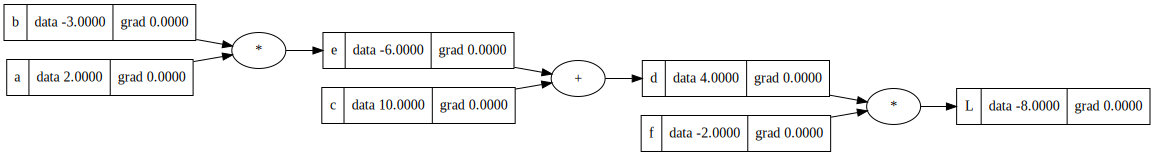

In [19]:
draw_dot(L)

# Computing Gradients using Chain Rule

We are now in a position to start computing gradients of `L` for the backward pass, with respect to all the variables that preceed it.

Let's review some basic [Differential Calculus](https://en.wikipedia.org/wiki/Derivative).

Consider, $L = f * d$.

What is $\frac{dL}{df}$?. The simple rules of derivatives tells us its, $d$.

Let's move a step back.

$d = c + e$.

We know that $\frac{dd}{de} = 1.0$.

Now, what's $\frac{dL}{de}$ ?

Using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule),

$\frac{dL}{de} = \frac{dL}{dd} \times \frac{dd}{de} = \frac{dL}{dd} \times 1.0 = \frac{dL}{dd}$

Similarly,
$\frac{dL}{dc} = \frac{dL}{dd}$.

Using these observations and the Chain Rule in general, we can write a `_backward()` function for addition and multiplication which calculates tha gradients of the output with respect to its children.



In [20]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = _children
    self.label = label
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad * 1.0
      other.grad += out.grad * 1.0
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

In [21]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [22]:
L.grad = 1.0 # init the gradient with 1.0
L._backward(); f._backward(); d._backward(); e._backward(); c._backward(); b._backward(); a._backward()

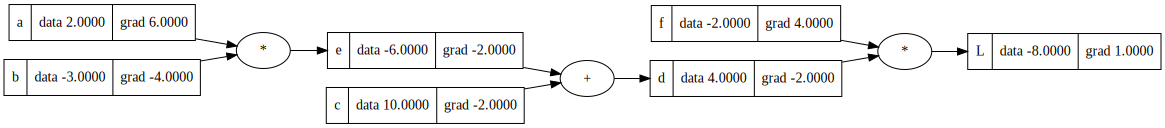

In [23]:
draw_dot(L)

Next, let's create a single `backward()` function to compute all the gradients in one go.

# Topological Sort

First, we want to convert the above graph into the sequence in which the nodes occur in the graph. This is done using [topological sort](https://en.wikipedia.org/wiki/Topological_sorting).

In [24]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(L)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=10.0),
 Value(data=4.0),
 Value(data=-2.0),
 Value(data=-8.0)]

The Values are in the correct order now. For the backward pass, we want to iterate this sequence in the reverse order and compute the gradients.

In [25]:
for node in reversed(topo):
  node._backward()

Let's wrap this functionality into a `backward()` function in the `Value` class.

In [26]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = _children
    self.label = label
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad * 1.0
      other.grad += out.grad * 1.0
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [27]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [28]:
L.backward()

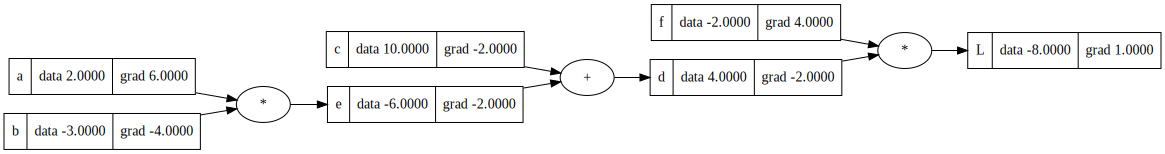

In [29]:
draw_dot(L)

Voila! We've successfully implemented the backward pass.

# Activation Functions

Next, let's add some activation functions in the mix. `tanh` and `relu` are two of the most popular activation functions.
$$ \tanh x={\frac {e^{2x}-1}{e^{2x}+1}}.$$

$$ ReLU(x)={\begin{cases}x&;{\text{if }}x>0,\\0&;{\text{otherwise}}\end{cases}}$$

The derivative of $\tanh$ turns out to be:
$$
\frac{d\tanh}{dx} = 1 - \tanh^2(x)
$$
$ReLU$'s derivative is trivial to work out.

In [30]:
def tanh(self):
  x = self.data
  t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
  out = Value(t, (self, ), 'tanh')

  def _backward():
    self.grad += (1 - t**2) * out.grad
  out._backward = _backward
  return out

def relu(self):
  out = Value(self.data if self.data > 0 else 0, (self, ), 'ReLU')

  def _backward():
    self.grad += (out.data > 0) * out.grad
  out._backward = _backward
  return out

# The AutoGrad Engine

Here's what our `Value` class now looks like, in its full glory. The `Value` class is now a full-fledged autograd engine, ready to train neural networks (See [part 2](https://darkknightxi.github.io/blog/posts/littlegrad/nn.html) for building and training neural nets).

In [31]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = _children
    self.label = label
    self._op = _op

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += out.grad * 1.0
      other.grad += out.grad * 1.0
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def relu(self):
    out = Value(self.data if self.data > 0 else 0, (self, ), 'ReLU')

    def _backward():
      self.grad += (out.data > 0) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

    def __repr__(self):
      return f"Value(data={self.data}, grad={self.grad})"

# Example using a Neural Network

Let's test our engine on a toy neural network.

In [32]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

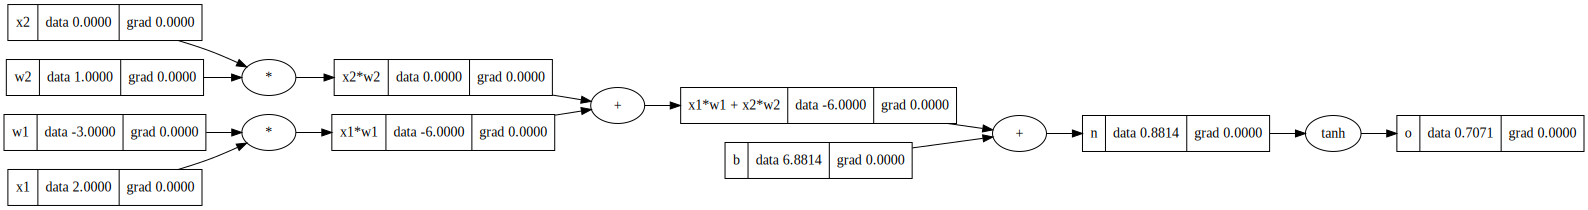

In [33]:
draw_dot(o)

In [34]:
o.backward()

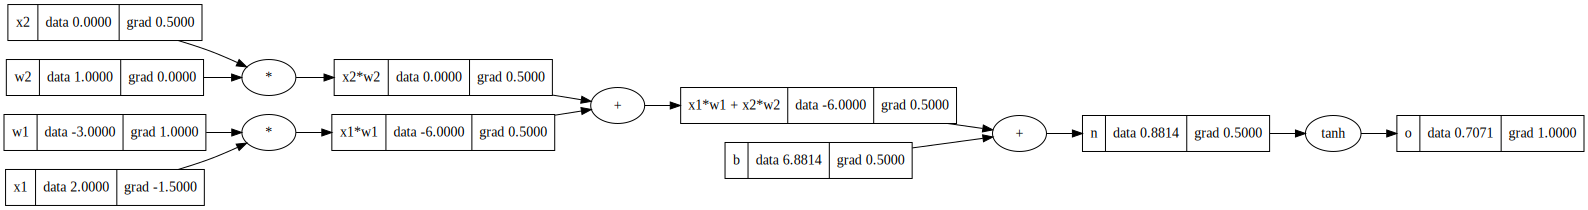

In [35]:
draw_dot(o)